In [1]:
%env OMP_NUM_THREADS=1
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt
from scattering import *
from mesh import *

env: OMP_NUM_THREADS=1


In [2]:
c = 340
h0 = 0.2

# Sphere

In [3]:
shape = "sphere"
a0 = b0 = 2.0
a1 = b1 = 2.25
R0 = 1.2
R1 = 1.9
if R0 is not None and R1 is not None:
    annular = True
else:
    annular = False

cached_mesh = True
if cached_mesh:
    mesh = fd.Mesh(shape + str(0) + ".msh")
else:
    mesh = generate_mesh(a0, a1, b0, b1, shape, h0, R0=R0, R1=R1)

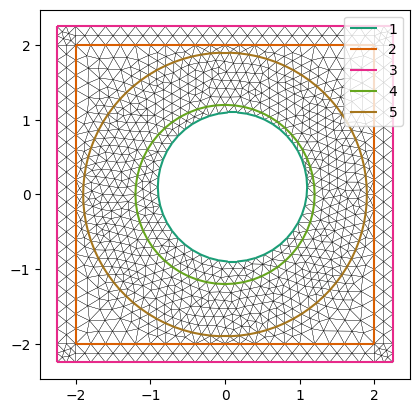

In [4]:
plot_mesh(mesh)

In [5]:
k = 5
d = fd.Constant([1., 0.])
x = fd.SpatialCoordinate(mesh)
kdx = k * fd.dot(d, x)
inc = fd.as_vector((fd.cos(kdx), fd.sin(kdx)))
g = -inc

uh = solve(mesh, k, a0, a1, b0, b1, g, annular=annular)

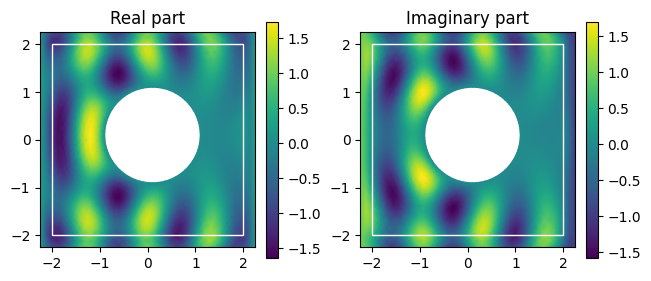

In [6]:
u = fd.interpolate(uh + inc, uh.function_space())
plot_field(u, a0, a1, b0, b1)

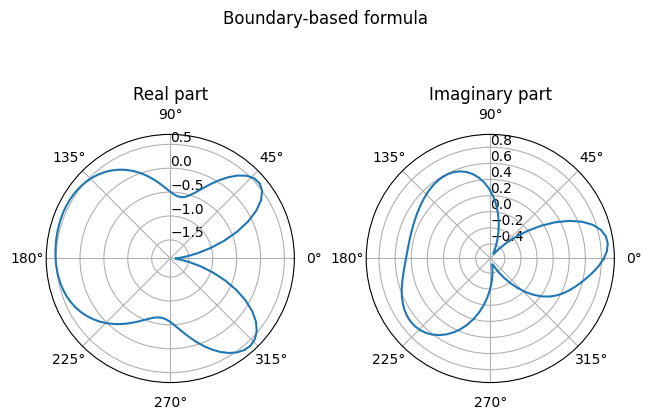

In [7]:
plot_far_field(k, uh)

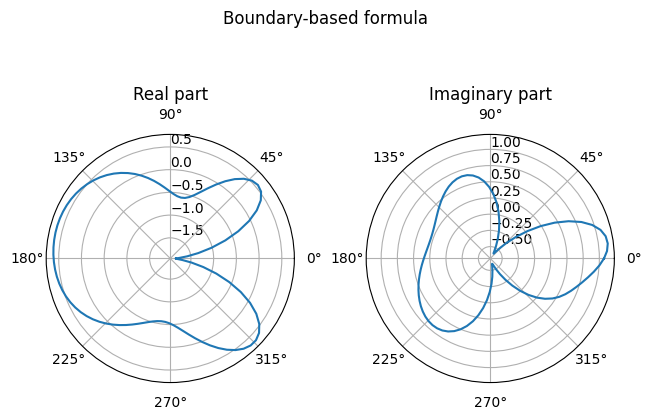

In [8]:
plot_far_field(k, uh, boundary=4)

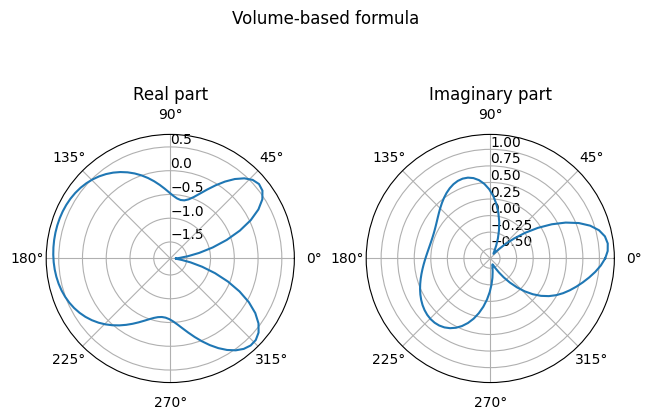

In [9]:
plot_far_field_vol(k, uh, R0, R1)

Text(0.5, 0.98, 'Reciprocity relation')

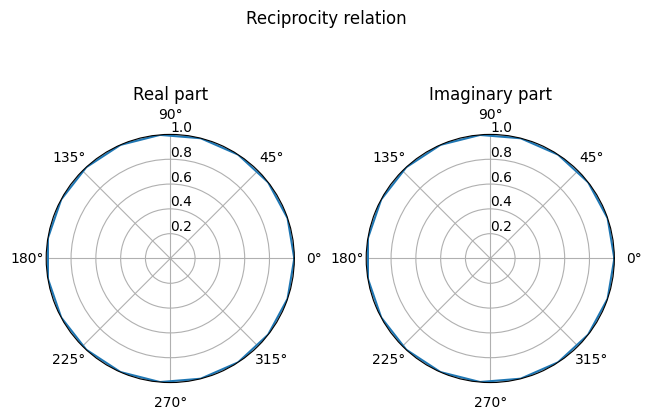

In [10]:
# reciprocity relation
# u_inf(x_hat, d) = u_inf(-d, -x_hat)

cached_mesh = True
if cached_mesh:
    mesh = fd.Mesh(shape + str(3) + ".msh")
else:
    mesh = generate_mesh(a0, a1, b0, b1, shape, h0, level=3, R0=R0, R1=R1)
k = 5
d = fd.Constant([1., 0.])
x = fd.SpatialCoordinate(mesh)
kdx = k * fd.dot(d, x)
inc = fd.as_vector((fd.cos(kdx), fd.sin(kdx)))
g = -inc
u1 = solve(mesh, k, a0, a1, b0, b1, g, annular=annular)

theta = np.linspace(0, 2 * np.pi, 20)
ratio = []
for t in list(theta):
    x_hat = fd.Constant((np.cos(t), np.sin(t)))
    u_inf1_re, u_inf1_im = far_field_vol(k, u1, x_hat, R0, R1)
    
    x = fd.SpatialCoordinate(mesh)
    kdx = k * fd.dot(-x_hat, x)
    inc = fd.as_vector((fd.cos(kdx), fd.sin(kdx)))
    g = -inc
    u2 = solve(mesh, k, a0, a1, b0, b1, g, annular=annular)
    u_inf2_re, u_inf2_im = far_field_vol(k, u2, -d, R0, R1)

    ratio.append((u_inf2_re / u_inf1_re, u_inf2_im / u_inf1_im))
ratio = np.array(ratio)

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'},
                               constrained_layout=True)
ax1.plot(theta, ratio[:, 0])
ax1.set_title("Real part")
ax1.set_rlabel_position(90)
ax1.grid(True)
ax2.plot(theta, ratio[:, 1])
ax2.set_title("Imaginary part")
ax2.set_rlabel_position(90)
ax2.grid(True)
fig.suptitle("Reciprocity relation")

# Kite

In [11]:
shape = "kite"
a0 = b0 = 2.75
a1 = b1 = 3.0
R0 = 2.3
R1 = 2.7
if R0 is not None and R1 is not None:
    annular = True
else:
    annular = False

cached_mesh = True
if cached_mesh:
    mesh = fd.Mesh(shape + str(0) + ".msh")
else:
    mesh = generate_mesh(a0, a1, b0, b1, shape, h0, R0=R0, R1=R1)

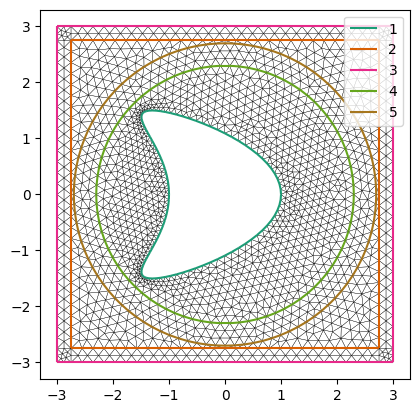

In [12]:
plot_mesh(mesh)

In [13]:
k = 1
d = fd.Constant((1., 0.))
x = fd.SpatialCoordinate(mesh)
kdx = k * fd.dot(d, x)
inc = fd.as_vector((fd.cos(kdx), fd.sin(kdx)))
g = -inc

uh = solve(mesh, k, a0, a1, b0, b1, g, annular=annular)

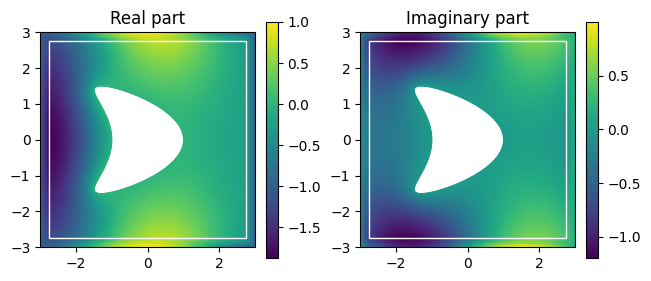

In [14]:
u = fd.interpolate(uh + inc, uh.function_space())
plot_field(u, a0, a1, b0, b1)

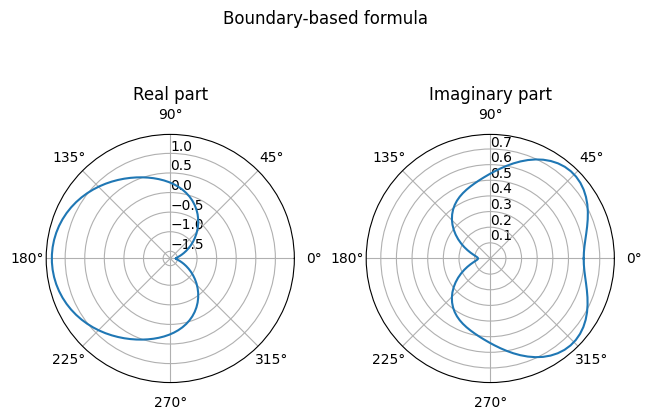

In [15]:
plot_far_field(k, uh)

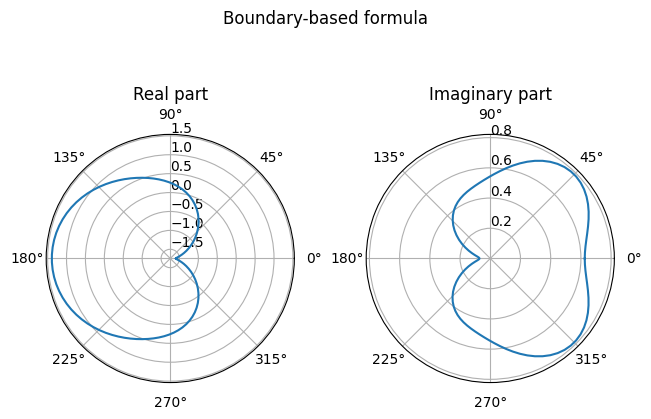

In [16]:
plot_far_field(k, uh, boundary=4)

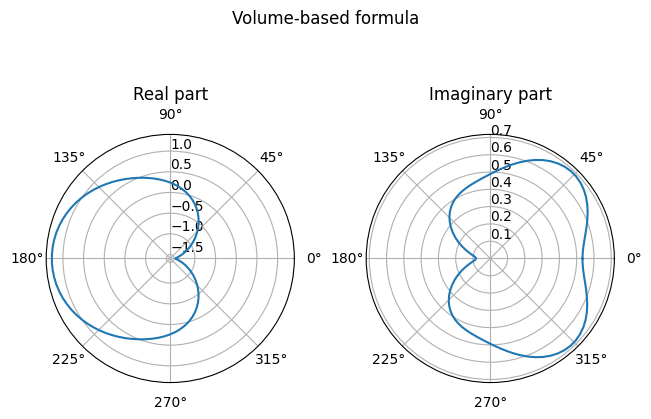

In [17]:
plot_far_field_vol(k, uh, R0, R1)

In [18]:
u_inf = far_field(k, uh, d)
print("Mesh-boundary-based:")
print("Re{u_inf(d)} =", u_inf[0])
print("Im{u_inf(d)} =", u_inf[1])

u_inf = far_field(k, uh, d, boundary=4)
print("Arbitrary-boundary-based:")
print("Re{u_inf(d)} =", u_inf[0])
print("Im{u_inf(d)} =", u_inf[1])

u_inf = far_field_vol(k, uh, d, R0, R1)
print("Volume-based:")
print("Re{u_inf(d)} =", u_inf[0])
print("Im{u_inf(d)} =", u_inf[1])

Mesh-boundary-based:
Re{u_inf(d)} = -1.538740416892908
Im{u_inf(d)} = 0.5972027635987636
Arbitrary-boundary-based:
Re{u_inf(d)} = -1.5934114779526536
Im{u_inf(d)} = 0.6254250228760194
Volume-based:
Re{u_inf(d)} = -1.4592750779171626
Im{u_inf(d)} = 0.5334733504517318


In [19]:
u_inf = far_field(k, uh, -d)
print("Mesh-boundary-based:")
print("Re{u_inf(d)} =", u_inf[0])
print("Im{u_inf(d)} =", u_inf[1])

u_inf = far_field(k, uh, -d, boundary=4)
print("Arbitrary-boundary-based:")
print("Re{u_inf(d)} =", u_inf[0])
print("Im{u_inf(d)} =", u_inf[1])

u_inf = far_field_vol(k, uh, -d, R0, R1)
print("Volume-based:")
print("Re{u_inf(d)} =", u_inf[0])
print("Im{u_inf(d)} =", u_inf[1])

Mesh-boundary-based:
Re{u_inf(d)} = 1.3409946650043645
Im{u_inf(d)} = 0.07777251528723382
Arbitrary-boundary-based:
Re{u_inf(d)} = 1.3891651664466163
Im{u_inf(d)} = 0.0711272450999821
Volume-based:
Re{u_inf(d)} = 1.2684388164634859
Im{u_inf(d)} = 0.08237016213884066


- $k = 1$  
    $Re\{u_\infty(d)\} = −1.62745750, Im\{u_\infty(d)\} = 0.60222591$  
    $Re\{u_\infty(-d)\} = 1.39694488, Im\{u_\infty(-d)\} = 0.09499635$  
- $k = 5$  
    $Re\{u_\infty(d)\} = -2.47554380, Im\{u_\infty(d)\} = 1.68747937$  
    $Re\{u_\infty(-d)\} = -0.19945787, Im\{u_\infty(-d)\} = 0.06015893$  
    (Colton and Kress - 2019, Table 3.1)

In [20]:
# Convergence
max_level = 5
levels = np.arange(max_level)
hs = h0 / 2**levels

In [21]:
mesh_hierarchy = []
if cached_mesh:
    for level in levels:
        mesh_hierarchy.append(fd.Mesh(shape + str(level) + ".msh"))
else:
    for level in levels:
        mesh_hierarchy.append(generate_mesh(a0, a1, b0, b1, shape, h0, level, R0=R0, R1=R1))

# mesh_hierarchy = fd.MeshHierarchy(mesh, max_level)

In [22]:
k = 1

if k == 1:
    u_inf_ref = np.array([-1.62745750, 0.60222591, 1.39694488, 0.09499635])
if k == 5:
    u_inf_ref = np.array([-2.47554380, 1.68747937, -0.19945787, 0.06015893])

k = 1
refinement level 0, relative error [0.05451269 0.00834097 0.04005184 0.18131049]
refinement level 1, relative error [0.02119153 0.0025297  0.01785045 0.05808426]
refinement level 2, relative error [0.01061738 0.00146458 0.01266292 0.09389016]
refinement level 3, relative error [0.00503338 0.00121862 0.00164529 0.03222903]
refinement level 4, relative error [0.0026222  0.00113996 0.00121552 0.0188892 ]


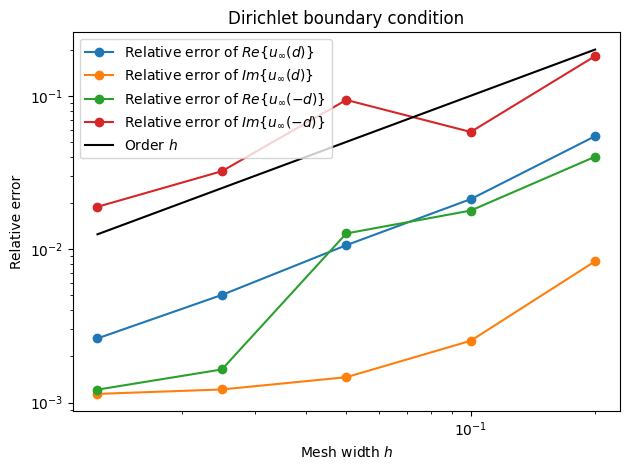

In [23]:
# Dirichlet problem
print(f"k = {k}")
errors = []
for level in levels:
    m = mesh_hierarchy[level]
    x = fd.SpatialCoordinate(m)
    kdx = k * fd.dot(d, x)
    inc = fd.as_vector((fd.cos(kdx), fd.sin(kdx)))
    g = -inc
    
    uh = solve(m, k, a0, a1, b0, b1, g, annular=annular)

    u_inf = np.empty(4)
    u_inf[0], u_inf[1] = far_field(k, uh, d)
    u_inf[2], u_inf[3] = far_field(k, uh, -d)
    rel_err = np.abs((u_inf - u_inf_ref) / u_inf_ref)
    print(f"refinement level {level}, relative error {rel_err}")
    errors.append(rel_err)
errors = np.array(errors)
plt.loglog(hs, errors[:, 0], "-o",
           label=r"Relative error of $Re\{u_\infty(d)\}$")
plt.loglog(hs, errors[:, 1], "-o",
           label=r"Relative error of $Im\{u_\infty(d)\}$")
plt.loglog(hs, errors[:, 2], "-o",
           label=r"Relative error of $Re\{u_\infty(-d)\}$")
plt.loglog(hs, errors[:, 3], "-o",
           label=r"Relative error of $Im\{u_\infty(-d)\}$")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

k = 1
refinement level 0, relative error [0.02091976 0.03852228 0.00556909 0.25126339]
refinement level 1, relative error [0.00409877 0.01243487 0.00053567 0.09181789]
refinement level 2, relative error [0.00195617 0.00580678 0.00397346 0.08021193]
refinement level 3, relative error [0.00052198 0.00246143 0.00289644 0.02565101]
refinement level 4, relative error [0.00042443 0.00066681 0.00100237 0.02228031]


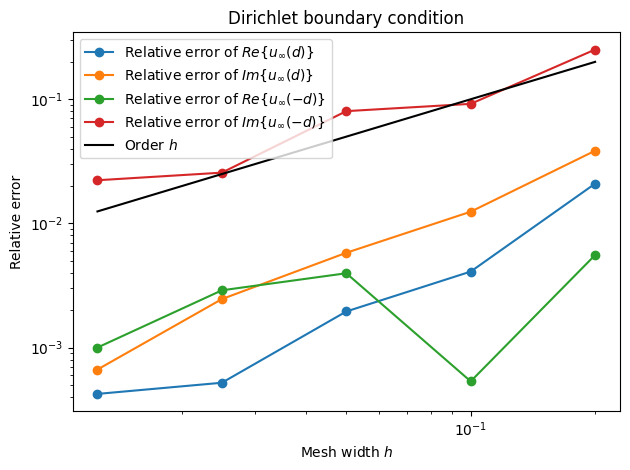

In [24]:
# Dirichlet problem
print(f"k = {k}")
errors = []
for level in levels:
    m = mesh_hierarchy[level]
    x = fd.SpatialCoordinate(m)
    kdx = k * fd.dot(d, x)
    inc = fd.as_vector((fd.cos(kdx), fd.sin(kdx)))
    g = -inc
    
    uh = solve(m, k, a0, a1, b0, b1, g, annular=annular)

    u_inf = np.empty(4)
    u_inf[0], u_inf[1] = far_field(k, uh, d, boundary=4)
    u_inf[2], u_inf[3] = far_field(k, uh, -d, boundary=4)
    rel_err = np.abs((u_inf - u_inf_ref) / u_inf_ref)
    print(f"refinement level {level}, relative error {rel_err}")
    errors.append(rel_err)
errors = np.array(errors)
plt.loglog(hs, errors[:, 0], "-o",
           label=r"Relative error of $Re\{u_\infty(d)\}$")
plt.loglog(hs, errors[:, 1], "-o",
           label=r"Relative error of $Im\{u_\infty(d)\}$")
plt.loglog(hs, errors[:, 2], "-o",
           label=r"Relative error of $Re\{u_\infty(-d)\}$")
plt.loglog(hs, errors[:, 3], "-o",
           label=r"Relative error of $Im\{u_\infty(-d)\}$")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

k = 1
refinement level 0, relative error [0.10334059 0.11416407 0.09199079 0.13291235]
refinement level 1, relative error [0.0308734  0.01254657 0.02305314 0.25895836]
refinement level 2, relative error [0.0080079  0.00260104 0.00971501 0.07508884]
refinement level 3, relative error [0.00224778 0.00014125 0.00120651 0.02645642]
refinement level 4, relative error [8.50211604e-04 6.00318212e-05 5.78985272e-04 2.23919174e-02]


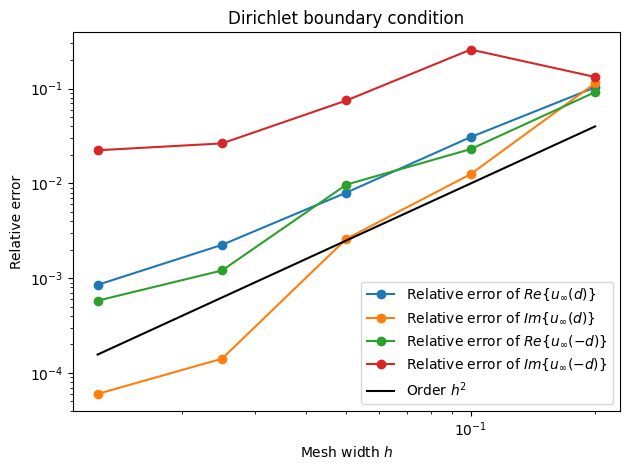

In [25]:
# Dirichlet problem
print(f"k = {k}")
errors = []
for level in levels:
    m = mesh_hierarchy[level]
    x = fd.SpatialCoordinate(m)
    kdx = k * fd.dot(d, x)
    inc = fd.as_vector((fd.cos(kdx), fd.sin(kdx)))
    g = -inc
    
    uh = solve(m, k, a0, a1, b0, b1, g, annular=annular)

    u_inf = np.empty(4)
    u_inf[0], u_inf[1] = far_field_vol(k, uh, d, R0, R1)
    u_inf[2], u_inf[3] = far_field_vol(k, uh, -d, R0, R1)
    rel_err = np.abs((u_inf - u_inf_ref) / u_inf_ref)
    print(f"refinement level {level}, relative error {rel_err}")
    errors.append(rel_err)
errors = np.array(errors)
plt.loglog(hs, errors[:, 0], "-o",
           label=r"Relative error of $Re\{u_\infty(d)\}$")
plt.loglog(hs, errors[:, 1], "-o",
           label=r"Relative error of $Im\{u_\infty(d)\}$")
plt.loglog(hs, errors[:, 2], "-o",
           label=r"Relative error of $Re\{u_\infty(-d)\}$")
plt.loglog(hs, errors[:, 3], "-o",
           label=r"Relative error of $Im\{u_\infty(-d)\}$")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()